# 3D Squirmer - puller

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import copy
import auxiliary5 as aux

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

%reload_ext autoreload
%autoreload 2

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
src_n = 38
dataDir = f'../data.lbm/{src_n}/'
# dataDir = f'../src/{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dataDir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

2

# Fluid

In [4]:
# id += 1
id = -1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y","id_z"]).sort_index()

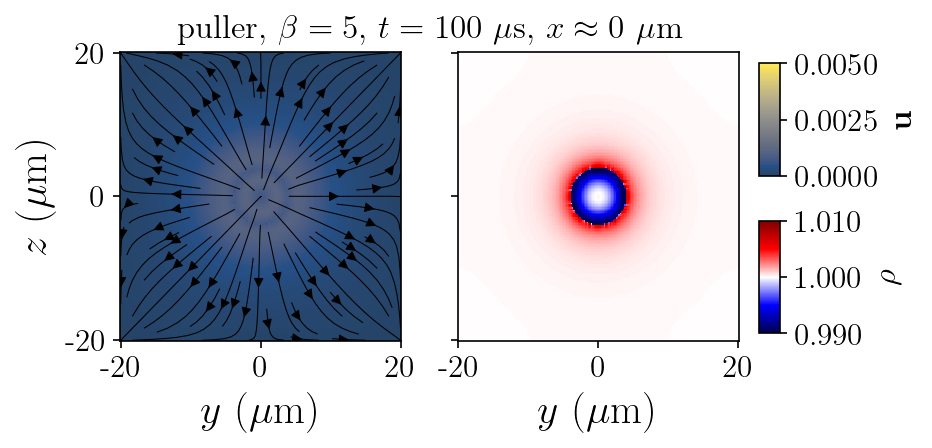

In [5]:
level = 0.1
title = "puller, $\\beta = 5,$ "+f"$t = {fluidDf.time.values[0]:.0f}$"+" $\\mu \\mathrm{s}$, "+f"$x \\approx {level:.0f}$"+" $\\mu \\mathrm{m}$"
fig, axes = aux.fluidOverviewX(fluidDf, title, level)
# plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")
plt.show()

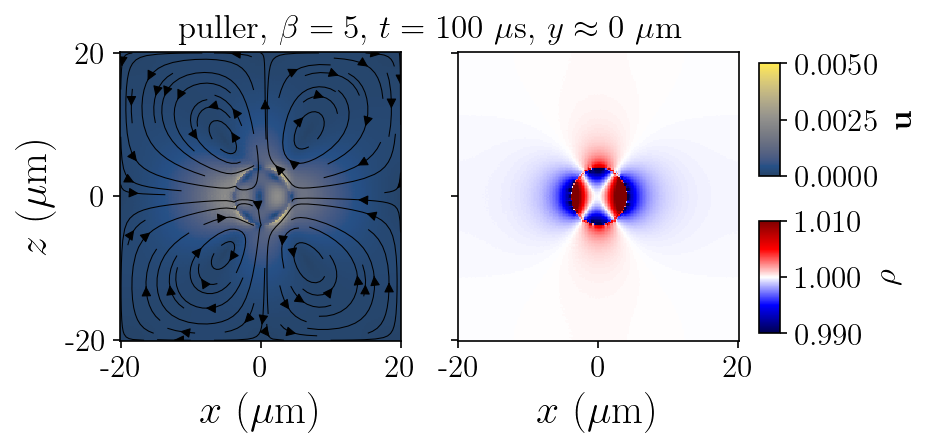

In [6]:
level = 0
title = "puller, $\\beta = 5,$ "+f"$t = {fluidDf.time.values[0]:.0f}$"+" $\\mu \\mathrm{s}$, "+f"$y \\approx {level:.0f}$"+" $\\mu \\mathrm{m}$"
fig, axes = aux.fluidOverviewY(fluidDf, title, level)
# plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")
plt.show()

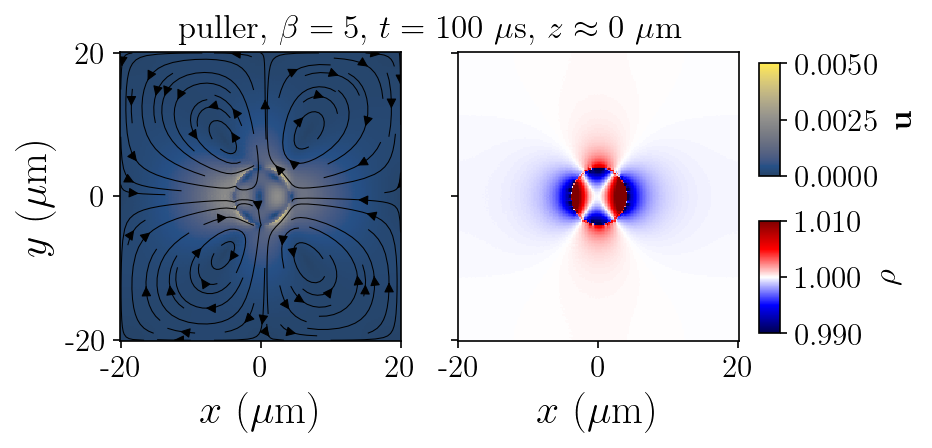

In [7]:
level = 0
title = "puller, $\\beta = 5,$ "+f"$t = {fluidDf.time.values[0]:.0f}$"+" $\\mu \\mathrm{s}$, "+f"$z \\approx {level:.0f}$"+" $\\mu \\mathrm{m}$"
fig, axes = aux.fluidOverviewZ(fluidDf, title, level)
# plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")
plt.show()

# Particle

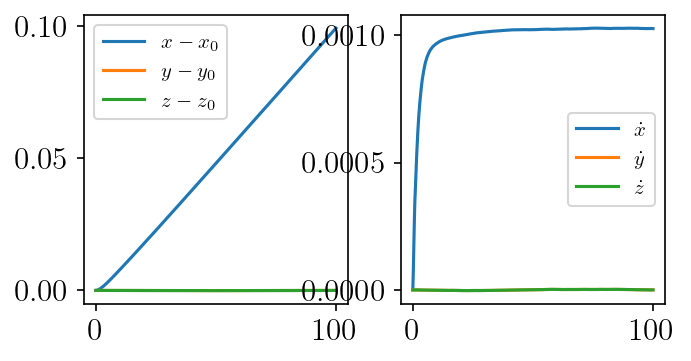

In [8]:
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")
fig, axes = aux.particleTrjOverview(particleDf)
plt.show()

## particle velocity is compared to analytical results

For a squirmer traveling towards $\mathbf{\hat{e}}$, its velocity will be given by
$$
    \mathbf{v} = \frac{2}{3} B_1 \mathbf{\hat{e}}
$$

The squirmer shown here is set to swim towards $\mathbf{\hat{x}}$.

In [9]:
flux_x = fluidDf.query('coordinate_x == -20').fluidVelocity_x.mean()
flux_y = fluidDf.query('coordinate_x == -20').fluidVelocity_y.mean()
flux_z = fluidDf.query('coordinate_x == -20').fluidVelocity_y.mean()

vAvgX = particleDf.velocity_x.mean()
vAvgY = particleDf.velocity_y.mean()
vAvgZ = particleDf.velocity_z.mean()

particleVelocityLabFrame = [vAvgX - flux_x, vAvgY - flux_y, vAvgZ - flux_z]
particleVelocityLabFrame # μm/μs

[np.float64(0.0009925677739918506),
 np.float64(-7.08365508943183e-08),
 np.float64(-7.083655089294782e-08)]

In [10]:
expectedSpeed = 1e-3
relativeError = np.abs(expectedSpeed - np.linalg.norm(particleVelocityLabFrame))/expectedSpeed
relativeError

np.float64(0.0074322209527597025)

# Stress tensor

In [ ]:
stressDf = pd.read_csv(dataDir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()
fig, axes = aux.stressTensorOverview(stressDf)
plt.show()

# Animation

In [11]:
# necessary directories are created
outputDir = f"frames.{src_n}"
os.system(f'mkdir -p anims')
os.system(f'mkdir -p {outputDir}/x')
os.system(f'mkdir -p {outputDir}/y')

# the data is read and frames are saved
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y","id_z"]).sort_index()
c = 1
for level in np.linspace(-20,20,151):
    print(f'\r{c/1.51:.1f}%', end='', flush=True)
    
    title = "puller, $\\beta = 5,$ "+f"$x \\approx {level:.2f}$"+" $\\mu \\mathrm{m}$"
    fig, axes = aux.fluidOverviewX(fluidDf, title, level)
    plt.savefig(f"{outputDir}/x/{c}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()
    
    title = "puller, $\\beta = 5,$ "+f"$y \\approx {level:.2f}$"+" $\\mu \\mathrm{m}$"
    fig, axes = aux.fluidOverviewY(fluidDf, title, level)
    plt.savefig(f"{outputDir}/y/{c}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()
    
    c+=1
    
print('\r'+' '*10, end='', flush=True)

# ffmpeg is used to create the animation
mkAnimSh = f'ffmpeg -framerate 15 -i {outputDir}/x/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -loglevel quiet anims/src_{src_n}_x.mp4'
os.system(mkAnimSh)
mkAnimSh = f'ffmpeg -framerate 15 -i {outputDir}/y/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -loglevel quiet anims/src_{src_n}_y.mp4'
os.system(mkAnimSh)

# the directory with the frames is erased
os.system(f'rm -r {outputDir}')

0